آزمایش نهم آزمایشگاه بینایی ماشین: شبکه های عصبی

دانشجو: سیدسعید جزائری

شماره دانشجویی: 98104885

## امتیازی
 :را به صورت زیر میسازیم AND مدل پرسپترون یک گیت

 ![](and.jpg)

In [1]:
from IPython.display import clear_output


!gdown 1NHSeb2w5D_9fxQQRKrmfGYnH0XU9uqkG
!unzip FER-2013.zip

clear_output(wait=False)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as img
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import torchvision
from torch.utils.data import Dataset, TensorDataset

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


<function matplotlib.pyplot.show(close=None, block=None)>

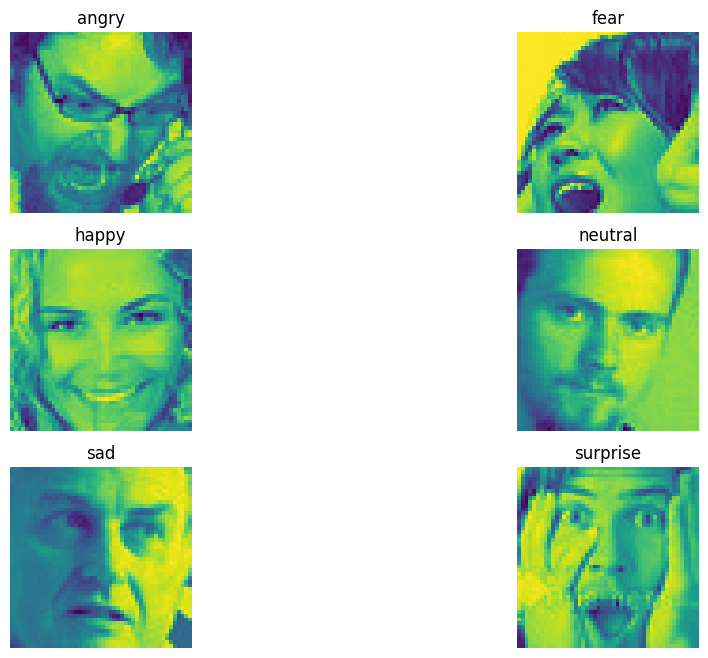

In [3]:
classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
names = ['PrivateTest_10131363', 'PrivateTest_10153550', 'PrivateTest_10077120', 'PrivateTest_10086748',
         'PrivateTest_10247676', 'PrivateTest_10072988']
plt.figure(figsize=(12,8))
for itr, clss in enumerate(classes):
    pic = img.imread(f'./FER-2013/val/{clss}/{names[itr]}.jpg')
    plt.subplot(3,2,itr+1)
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"{clss}")
plt.show


In [ ]:
X_train = []
y_train = []

for itr, clss in enumerate(classes):
    path = './FER-2013/train/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        temp = temp.flatten()
        X_train.append(np.array(temp)/255.0)
        y_train.append(torch.tensor(itr, dtype=torch.long))

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_val = []
y_val = []

for itr, clss in enumerate(classes):
    path = './FER-2013/val/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        temp = temp.flatten()
        X_val.append(np.array(temp)/255.0)
        y_val.append(torch.tensor(itr, dtype=torch.long))

X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_test = []
y_test = []

for itr, clss in enumerate(classes):
    path = './FER-2013/test/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        temp = temp.flatten()
        X_test.append(np.array(temp)/255.0)
        y_test.append(torch.tensor(itr, dtype=torch.long))

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = map(torch.tensor, (X_train, X_val, X_test, y_train, y_val, y_test))


mean = X_train.mean(dim=0)
std = X_train.std(dim=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std



train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64 , shuffle=False)

In [ ]:
class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(in_features=48*48, out_features=6)

    def forward(self, x):
        x = F.softmax(self.fc(x))
        return x


model = SingleLayerNN().to(device)
learning_rate = 0.0001
weight_decay = 0.001
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


history = {
  'loss': [],
  'val_loss': [],
  'acc': [],
  'val_acc': []
}
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        # print(labels.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()



    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Accuracy: {train_correct / train_total:.4f} - "
          f"Train Loss: {train_loss / len(train_loader):.4f} - "
          f"Validation Accuracy: {val_correct / val_total:.4f} - "
          f"Validation Loss: {val_loss / len(val_loader):.4f}")

    history['acc'].append(train_correct / train_total)
    history['loss'].append(train_loss / len(train_loader))
    history['val_acc'].append(val_correct / val_total)
    history['val_loss'].append(val_loss / len(val_loader))


Epoch 1/50 - Train Accuracy: 0.2951 - Train Loss: 1.7283 - Validation Accuracy: 0.3265 - Validation Loss: 1.7016
Epoch 2/50 - Train Accuracy: 0.3516 - Train Loss: 1.6858 - Validation Accuracy: 0.3772 - Validation Loss: 1.6730
Epoch 3/50 - Train Accuracy: 0.3719 - Train Loss: 1.6680 - Validation Accuracy: 0.3780 - Validation Loss: 1.6614
Epoch 4/50 - Train Accuracy: 0.3817 - Train Loss: 1.6583 - Validation Accuracy: 0.3848 - Validation Loss: 1.6564
Epoch 5/50 - Train Accuracy: 0.3874 - Train Loss: 1.6522 - Validation Accuracy: 0.3820 - Validation Loss: 1.6535
Epoch 6/50 - Train Accuracy: 0.3922 - Train Loss: 1.6474 - Validation Accuracy: 0.3933 - Validation Loss: 1.6487
Epoch 7/50 - Train Accuracy: 0.3943 - Train Loss: 1.6437 - Validation Accuracy: 0.3896 - Validation Loss: 1.6463
Epoch 8/50 - Train Accuracy: 0.3992 - Train Loss: 1.6401 - Validation Accuracy: 0.3905 - Validation Loss: 1.6441
Epoch 9/50 - Train Accuracy: 0.4018 - Train Loss: 1.6374 - Validation Accuracy: 0.3953 - Validat

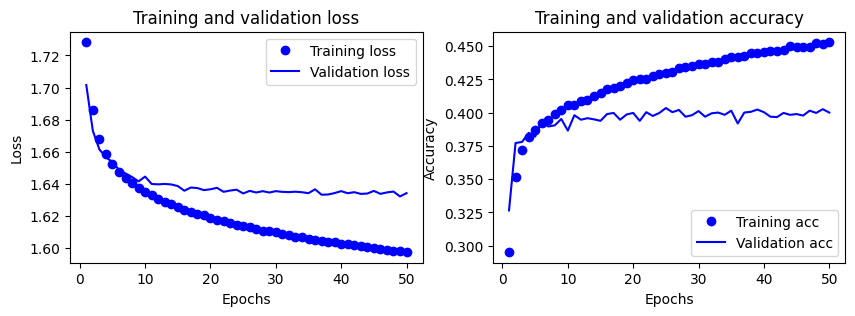

In [ ]:
def visualize_loss_and_acc(history_dict):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

visualize_loss_and_acc(history)



ناشی از همین است. Valid  و  Train  انجام داده ایم و این فاصله میان  Train را به معنای کسر میانگین از داده ها و تقسیم به واریانس، بر اساس داده های Transform دقت کنید که ما عملیات

Test set accuracy = 40.64534390036796 %


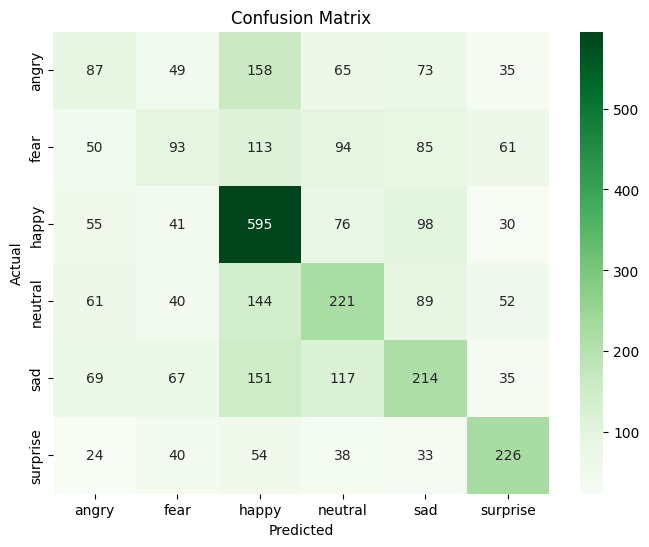

In [ ]:
test_acc=0
model.eval()

y_predc = []

with torch.no_grad():
	for i, (images, labels) in enumerate(test_loader):

		images = images.to(device)
		y_true = labels.to(device)

		outputs = model(images.float())

		_, y_pred = torch.max(outputs.data, 1)

		y_pred2 = y_pred.cpu().numpy().tolist()
		y_predc = y_predc + y_pred2

		test_acc += (y_pred == y_true).sum().item()

	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

conf_mat = confusion_matrix(y_test.to('cpu'), y_predc)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

واضح است که یک مدل شبکه عصبی تک لایه، مخصوصا در حالتی که تصاویر را به بردار های تک بعدی با تعداد ویژگی برابر با تعداد پیکسل ها عملکرد بینظیری نخواهد داشت.

به دقت حدود 40 رسیده ایم که از حالت رندوم آن یعنی حدود 17 درصد مقدار معقولی بهتر است. epoch در این حالت بعد از 50 مرتبه  

In [ ]:
class MultiLayerNN(nn.Module):
    def __init__(self):
        super(MultiLayerNN, self).__init__()
        self.fc1 = nn.Linear(in_features=48*48, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=6)



    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        return x

In [ ]:
model = MultiLayerNN().to(device)
learning_rate = 0.0001
weight_decay = 0.001
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


history = {
  'loss': [],
  'val_loss': [],
  'acc': [],
  'val_acc': []
}
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        # print(labels.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()



    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Accuracy: {train_correct / train_total:.4f} - "
          f"Train Loss: {train_loss / len(train_loader):.4f} - "
          f"Validation Accuracy: {val_correct / val_total:.4f} - "
          f"Validation Loss: {val_loss / len(val_loader):.4f}")

    history['acc'].append(train_correct / train_total)
    history['loss'].append(train_loss / len(train_loader))
    history['val_acc'].append(val_correct / val_total)
    history['val_loss'].append(val_loss / len(val_loader))

Epoch 1/50 - Train Accuracy: 0.3152 - Train Loss: 1.7067 - Validation Accuracy: 0.3698 - Validation Loss: 1.6601
Epoch 2/50 - Train Accuracy: 0.3818 - Train Loss: 1.6496 - Validation Accuracy: 0.3877 - Validation Loss: 1.6424
Epoch 3/50 - Train Accuracy: 0.3986 - Train Loss: 1.6336 - Validation Accuracy: 0.3976 - Validation Loss: 1.6332
Epoch 4/50 - Train Accuracy: 0.4118 - Train Loss: 1.6213 - Validation Accuracy: 0.3956 - Validation Loss: 1.6323
Epoch 5/50 - Train Accuracy: 0.4255 - Train Loss: 1.6097 - Validation Accuracy: 0.4038 - Validation Loss: 1.6239
Epoch 6/50 - Train Accuracy: 0.4387 - Train Loss: 1.5974 - Validation Accuracy: 0.4015 - Validation Loss: 1.6249
Epoch 7/50 - Train Accuracy: 0.4511 - Train Loss: 1.5874 - Validation Accuracy: 0.4145 - Validation Loss: 1.6195
Epoch 8/50 - Train Accuracy: 0.4646 - Train Loss: 1.5759 - Validation Accuracy: 0.4284 - Validation Loss: 1.6008
Epoch 9/50 - Train Accuracy: 0.4759 - Train Loss: 1.5644 - Validation Accuracy: 0.4151 - Validat

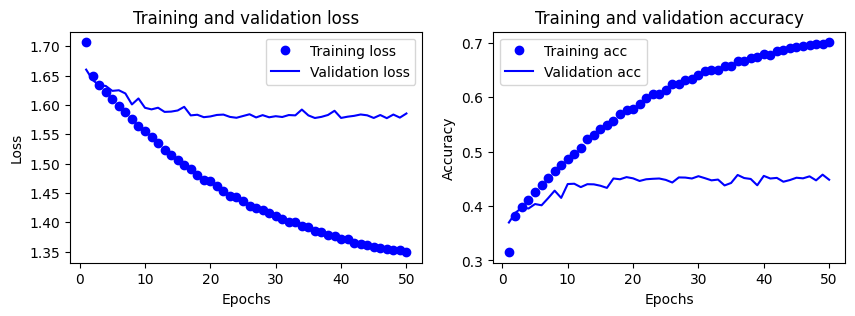

Test set accuracy = 44.57967732804982 %


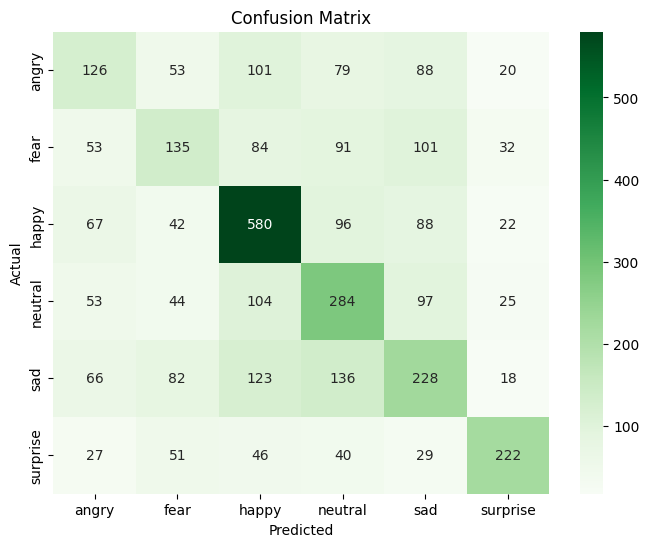

In [ ]:
visualize_loss_and_acc(history)



test_acc=0
model.eval()

y_predc = []

with torch.no_grad():
	for i, (images, labels) in enumerate(test_loader):

		images = images.to(device)
		y_true = labels.to(device)

		outputs = model(images.float())

		_, y_pred = torch.max(outputs.data, 1)

		y_pred2 = y_pred.cpu().numpy().tolist()
		y_predc = y_predc + y_pred2

		test_acc += (y_pred == y_true).sum().item()

	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

conf_mat = confusion_matrix(y_test.to('cpu'), y_predc)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

.مشاهده نمیشود Test و  Validation افزایش یافته و به همان میزان خطا کم شده است، اثر مشهودی روی دقت مدل بر روی داده های  Train واضح است با اضافه کردن لایه های مخفی، علی رغم اینکه دقت مدل برروی داده های

شدن مدل میشود. Overfit به نوعی میتوان گفت اضافه کردن بی مورد لایه های مخفی به مدل، باعث

### بررسی تغییر پارامترها: Learning Rate

In [ ]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for lr in learning_rates:
    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = 40
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()



    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)


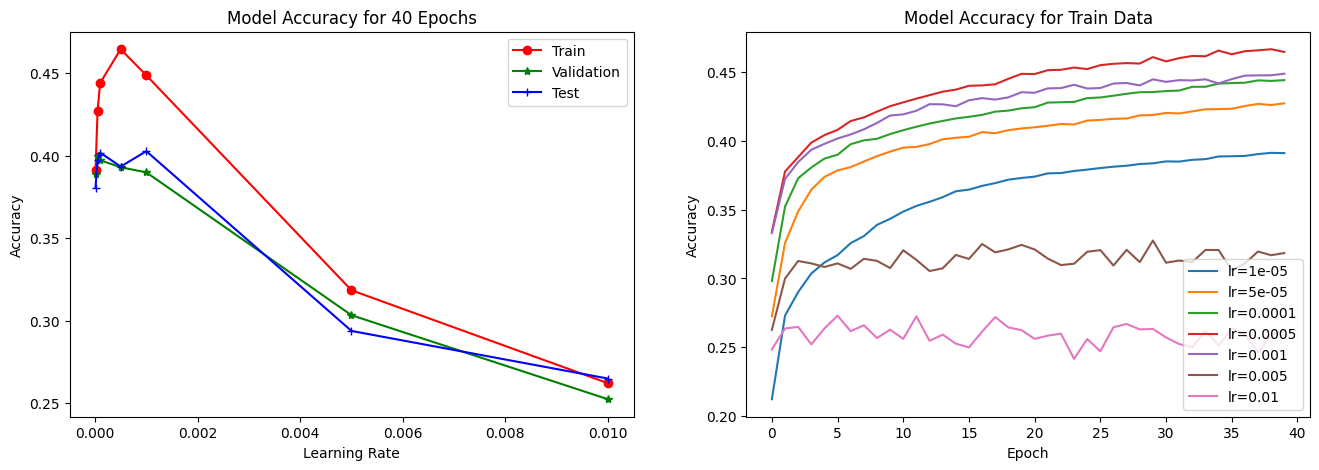

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(learning_rates, history['train_acc'], '-o', color='r', label='Train')
plt.plot(learning_rates, history['val_acc'], '-*', color='g', label='Validation')
plt.plot(learning_rates, history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for 40 Epochs")

plt.legend()


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(epochs), curve, label=f'lr={learning_rates[itr]}')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for Train Data")

plt.legend()

plt.show()


### :به شرح زیر است Learning Rate بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### 1) دقت مدل
بر دقت نهایی مدل اثرگذار است. به این معنا که این متغیر نباید چندان بزرگ انتخاب شود چرا که بر تغییر مقدار وزن نورون ها به صورت نمایی اثر میگذارد Learning Rate از منحنی سمت چپ مشخص است که مقدار عددی

#### 2) سرعت همگرا شدن
باعث همگرایی سریعتر میشود. در مقابل مقدار کم این ابرپارامتر، منجر میشود که همگرا شدن بیشتر طول بکشد. بدیهی است که علی رغم اینکه با بزرگ انتخاب شدن این ابرپارامتر زودتر به همگرایی میرسیم، اما دقت مدل مناسب نیست و پایداری مناسب رعایت نشده است Learning Rate از منحنی های سمت راست و تغییرات آن ها در راستای ایپاک، مشخص است که مقادیر بزرگتر

#### 3) Underfitting اثر بر میزان
 با   بررسی منحنی های سمت چپ میبینیم که با زیاد کردن این ابرپارامتر، مدل حتی رفتار داده های آموزش را نیز به خوبی یاد نگرفته است و دقت آن با زیاد شدن این ابرپارامتر، کاهش میابد. بنابراین برای جلوگیری از آندرفیت شدن نباید این ابرپارامتر بی توجه بزرگ انتخاب شود   

#### 4) گذر از بهینه یهای محلی
 .بیشتر است lr=0.01 و lr=0.00001 از هر دو حالت lr=0.0005 با بررسی منحنی های سمت راست میبینم که دقت مدل به ازای

 یعنی بسیار بزرگ انتخاب شدن آن یا بسیار کوچک انتخاب شدن آن منجر میشود مدل در بهینه های مینیمم محلی یا ماکسیمم محلی گیر کند و نتواند با گرادیان به سمت بهینه گلوبال حرکت کند. بنابراین باید این متغیر معقول و متعادل انتخاب شود

### بررسی تغییر پارامترها: Optimizer

In [ ]:
optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad']
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for opt in optimizers:
    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = 40
    criterion = nn.CrossEntropyLoss()
    if opt=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
    elif opt=='Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    elif opt=='RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=weight_decay)
    elif opt=='Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=weight_decay)

    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()



    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)


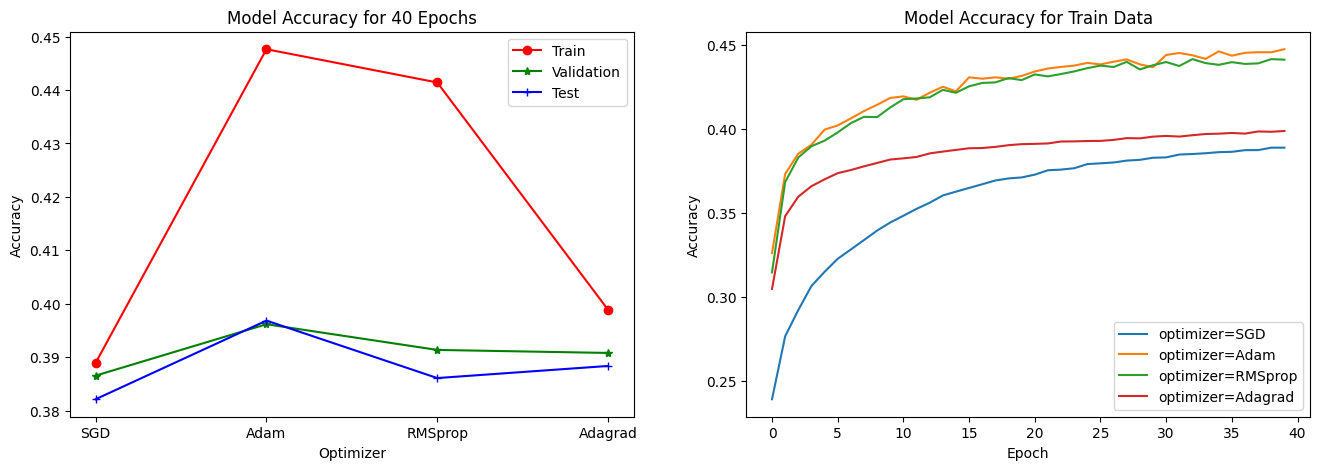

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot([0, 1, 2, 3], history['train_acc'], '-o', color='r', label='Train')
plt.plot([0, 1, 2, 3], history['val_acc'], '-*', color='g', label='Validation')
plt.plot([0, 1, 2, 3], history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for 40 Epochs")
plt.xticks([0, 1, 2, 3], optimizers)

plt.legend()


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(epochs), curve, label=f'optimizer={optimizers[itr]}')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for Train Data")

plt.legend()

plt.show()

### :به شرح زیر است Optimizer  بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### بدیهی است در کاربرد های مختلف و نوع داده ای که برروی آن قرار است آموزش صورت بگیرد،اپتیمایزر متفاوت خواهد بود و البته اثر زیادی دارد. بنابراین لازم است بنابه شرایط از اپتیمایزر مناسب استفاده کنیم. ولی کلیت توضیحات به شرح زیر است  
- SGD: الگوریتم ساده مبتنی بر گرادیان است و پارامتر ها را برمبنای این روش آپدیت میکند. چون از پیچیدگی محاسباتی کمتری برخوردار است سرعت بالاتری دارد اما همانوطر که در هر دو شکل سمت چپ و راست واضح است، منجر به دقت کمتری خواهد شد

- Adam: متداول ترین نوع اپتیمایزر است و از ترکیب ایده ی مومنتوم و «آر ام اس پروپ» تشکیل شده است. بر اساس تاریخچه ای که از گرادیان ها ذخیره میکند به آپدیت پارامتر ها مییپردازد و برای کاربردهایی به دیتاست بزرگ مناسب است. بنابراین مزیت مومنتم و «آر ام اس پروپ» را هم زمان دارد و برای انواع گوناگونی از داده ها مناسب است.
در مقابل در حالات کم دیتاست، احتمال اورفیتینگ بیشتر دارد و همینطور از منابع مموری بیشتری استفاده میکند

- RMSpro: در این روش با تغییر ابرپارامتر «لرنینگ ریت» با تقسیم آن به میانگین خطای ام اس ای گرادیان ها، به صورت آداپتیو به آپدیت پارامتر ها میپردازد.
بنابراین این آداپتیو بودن برای کیس های با مدل چند لایه آن را مناسب کرده است. همینطور برای انواع متنوعی از داده ها بسیار پاسخگوست و میبینیم در کیس ما نیز بیشترین دقت را در هر سه دسته آموزش، ولیدیشن و تست داشته است.
در مقابل نرخ همگرا شدن بیشتری دارد و استعداد بیشتری برای واگرا شدن دارد که در شکل سمت راست نیز مشخص است

- Adagrad: با گذر دادن یک پنجره از گرادیان ها به محاسبه مومنتوم دوم گرادیان میپردازد و به این شیوه تصمیم به آپدیت پارامتر ها میکند. بنابراین به طور انطباقی آپدیت پارامتر ها صورت میگیرد که «پارامتر لرنینگ ریت» را در مرور زمان کاهش میدهد

مموری کمی لازم دارد و در عوض چون به پارامتر «لرنینگ ریت» دست میزند ممکن است عوارض ناشی از کوچک بودن آن را به دنبال داشته باشد


منبع: https://medium.com/@ahmadsabry678/various-types-of-optimizers-in-deep-learning-advantages-and-disadvantages-for-each-type-ed42ba1609d

### بررسی تغییر پارامترها: Batch Size

In [ ]:
BatchSizes = [16, 32, 64, 128]
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for bs in BatchSizes:
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = 40
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()



    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)


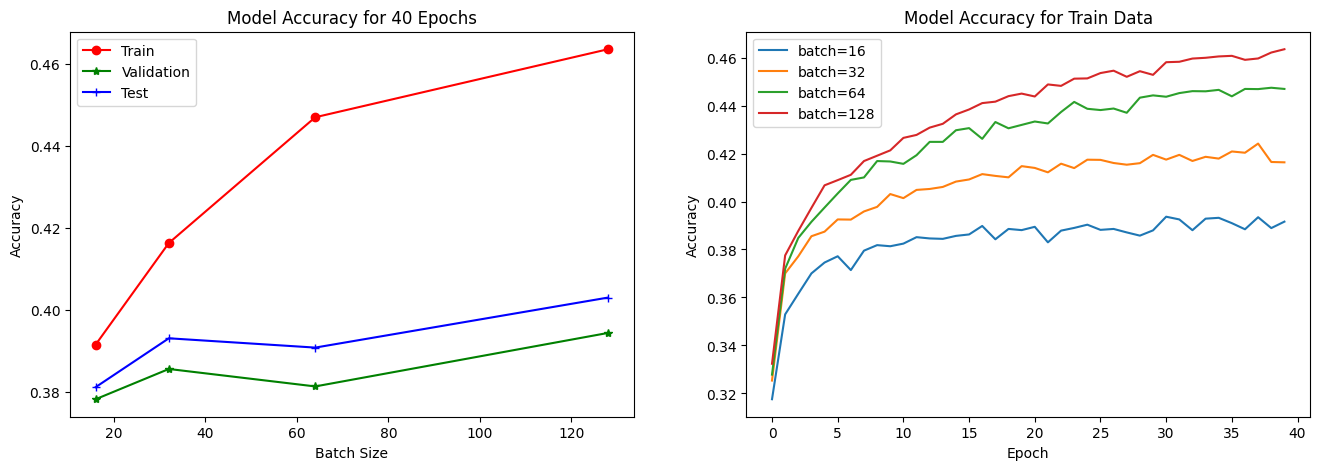

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(BatchSizes, history['train_acc'], '-o', color='r', label='Train')
plt.plot(BatchSizes, history['val_acc'], '-*', color='g', label='Validation')
plt.plot(BatchSizes, history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for 40 Epochs")

plt.legend()


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(epochs), curve, label=f'batch={BatchSizes[itr]}')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for Train Data")

plt.legend()

plt.show()


### :به شرح زیر است Batch Size  بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### 1) دقت مدل:
از هردودسته نمودار های فوق واضح است که بزرگتر بودن «بچ سایز» منجر به دقت بیشتری در مدل نهایی میشود

#### 2)سرعت همگرایی:
واضح است که بچ سایز های کوچکتر هرچند به دقت کمتر، اما سریعتر همگرا شده اند. بنابراین سرعت همگرایی با «بچ سایز» رابطه ی عکس دارد

#### 3) میزان استفاده از منابع:
چون داده ها به اندازه «بچ سایز» در هر مرحله در مموری لود میشوند، سیستم هایی که سخت افزار ضعیف تری دارند انتخاب «بچ سایز» کوچکتر به آن ها کمک میکند تا بتوانند فرایند آموزش را بدون مشکل انجام دهند. بنابراین بر میزان استفاده از مموری اثرگذار است

#### 4) عمومیت آموزش
اگر «بچ سایز» را کوچک انتخاب کنیم، چون ضرایب و پارامتر ها تعداد دفعات بیشتری آپدیت میشوند احتمالا از عمومیت بالاتری برخوردار هستند و انتظار نزدیکی بیشتری میان دقت تست و ترین داریم که در شکل بالا سمت چپ هم واضح است. از طرفی اگر «بچ سایز» بزرگ باشد احتمال اورفیتینگ را افزایش میدهد


### بررسی تغییر پارامترها: Number of Epoch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

NumEpochs = [1, 2, 5, 10, 20, 35, 50, 70]
history = {
      'train_acc': [],
      'val_acc': [],
      'test_acc': []
    }

train_acc_epochs = []

for epc in NumEpochs:

    model = SingleLayerNN().to(device)
    weight_decay = 0.001
    epochs = epc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    accs = []

    for epoch in range(epochs):
        model.train()

        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accs.append(train_correct / train_total)


        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()



    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)
    history['test_acc'].append(test_correct / test_total)
    train_acc_epochs.append(accs)


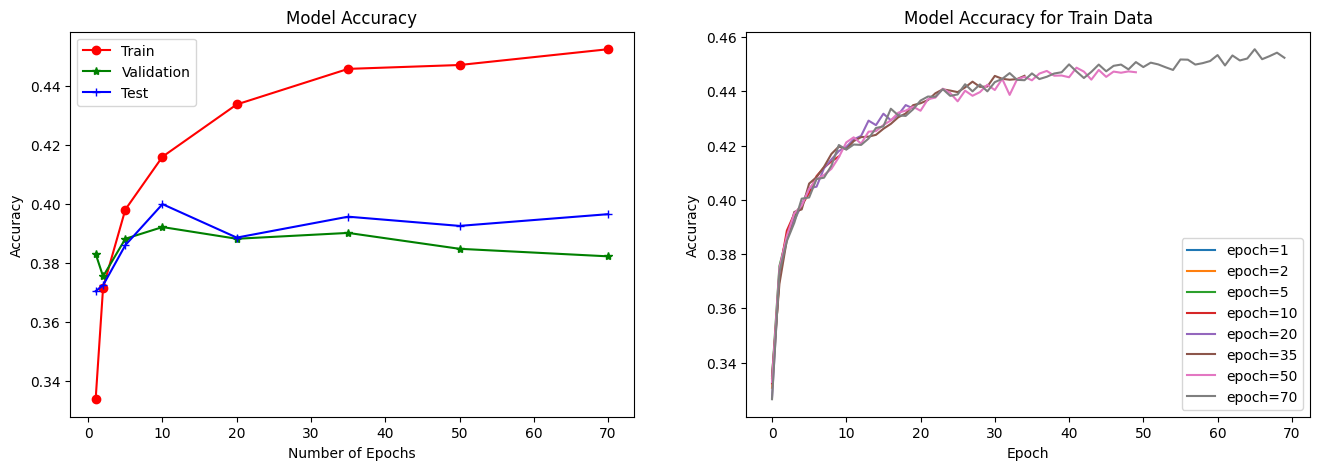

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(NumEpochs, history['train_acc'], '-o', color='r', label='Train')
plt.plot(NumEpochs, history['val_acc'], '-*', color='g', label='Validation')
plt.plot(NumEpochs, history['test_acc'], '-+', color='b', label='Test')

plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.legend()


plt.subplot(1,2,2)
for itr, curve in enumerate(train_acc_epochs):
    plt.plot(range(len(curve)), curve, label=f'epoch={NumEpochs[itr]}')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for Train Data")

plt.legend()

plt.show()


### :به شرح زیر است Number of Epochs  بابررسی دو دسته منحنی فوق واضح است اثرات ابرپارامتر

#### 1) آندرفیتینگ و اورفیتینگ:
مهم ترین اثرگذاری تعداد «ایپاک» اثرگذاری بر دو مفهوم آندرفیتینگ و اورفیتینگ است. همانطور که از شکل بالا سمت چپ هم پیداست، تعداد ایپاک کم منجر به آندرفیتینگ میشود به نحوی که دقت مدل برروی داده های تست از داده های آموزش بیشتر است. از طرف دیگر تعداد ایپاک زیاد منجر به اورفیتینگ میشود به نحوی که دقت مدل برای داده های آموزش بیشتر شده است ولی دقت برای داده های تست تقریبا ثابت مانده است

#### 2) مصرف منابع پردازشی
بدیهی است تعداد ایپاک بیشتر، به زمان بیشتری برای آموزش شبکه و مدل لازم دارد و بنابراین منابع سخت افزاری از جمله پردازنده مرکزی و پردازنده گرافیکی و مموری را بیشتر تحت فشار قرار میدهد

#### 3) همگرایی
همانطور که از دسته منحنی های شکل سمت راست پیداست، مطابق انتظار این منحنی ها با هم همپوشانی زیادی دارند و رفتار آن ها به صورت تکه خطی مشابه هم است. اما برای ایپاک های کم مدل به همگرایی نرسیده و مشتق آن همچنان زیاد است اما برای ایپاک های بزرگ میبینیم که مدل تقریبا به همگرایی و ماکسیمم دقت خود رسیده است

#### 4) ابزار دیباگ به کمک ولیدیشن
با توجه به اینکه میتوان فرایند یادگیری را پس از هر مرحله ایپاک متوقف کرد و در فرصت بعدی از ادامه ی آن یادگیری را ادامه داد، تعداد ایپاک این قابلیت را میدهد که
آموزش مدل را برای ایپاک های بیشتر ذخیره کرد و بعدا بیشتر یاد داد. برای اینکار باید یک فایل «چک پوینتس» از مدل ذخیره کرد

# CNN


In [5]:
X_train = []
y_train = []
for itr, clss in enumerate(classes):
    path = './FER-2013/train/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        X_train.append(np.array(temp)/255.0)
        y_train.append(torch.tensor(itr, dtype=torch.long))
X_train = np.array(X_train)
y_train = np.array(y_train)


X_val = []
y_val = []
for itr, clss in enumerate(classes):
    path = './FER-2013/val/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        X_val.append(np.array(temp)/255.0)
        y_val.append(torch.tensor(itr, dtype=torch.long))
X_val = np.array(X_val)
y_val = np.array(y_val)


X_test = []
y_test = []
for itr, clss in enumerate(classes):
    path = './FER-2013/test/' + clss
    pics = os.listdir(path)
    for pic in pics:
        temp = img.imread(path + '/' + pic)
        X_test.append(np.array(temp)/255.0)
        y_test.append(torch.tensor(itr, dtype=torch.long))
X_test = np.array(X_test)
y_test = np.array(y_test)






X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))





X_train, X_val, X_test, y_train, y_val, y_test = map(torch.tensor, (X_train, X_val, X_test, y_train, y_val, y_test))

normalize_transform = torchvision.transforms.Compose([
    # torchvision.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                     std = (0.5, 0.5, 0.5))
    ])

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)

        y = self.target[index]
        if self.target_transform:
            y = self.target_transform(y)

        return x, y

train_dataset = MyDataset(X_train, y_train)#, transform=normalize_transform)
val_dataset = MyDataset(X_val, y_val)#, transform=normalize_transform)
test_dataset = MyDataset(X_test, y_test)#, transform=normalize_transform)

In [6]:
class MyCnn(nn.Module):
    def __init__(self):
        super(MyCnn, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv2 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

        self.conv3 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)


        self.fc1 = torch.nn.Linear(32*6*6, 512)
        self.fc2 = torch.nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))

        x = x.view(-1, 32*6*6)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [7]:
approaches = [
    {'Batch': 128, 'Epoch': 30, 'Optimizer': 'Adam', 'LearningRate': 0.001},
    {'Batch': 64, 'Epoch': 30, 'Optimizer': 'َSGD', 'LearningRate': 0.005},
    {'Batch': 128, 'Epoch': 30, 'Optimizer': 'RMSprop', 'LearningRate': 0.001},
    {'Batch': 256, 'Epoch': 30, 'Optimizer': 'RMSprop', 'LearningRate': 0.005},
]


ALL_HIST = []
ALL_VAL_ACC = []
ALL_MODELS = []
for na, aprch in enumerate(approaches):
    print(f'########## Approach: {na+1} ##########')


    train_loader = DataLoader(train_dataset, batch_size=aprch['Batch'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=aprch['Batch'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=aprch['Batch'], shuffle=False)

    history = {
          'train_acc': [],
          'val_acc': [],
          'val_loss': [],
          'test_acc': []
        }

    val_acc_epochs = []

    model = MyCnn().to(device)
    weight_decay = 0.001
    epochs = aprch['Epoch']
    criterion = nn.CrossEntropyLoss()
    if aprch['Optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=aprch['LearningRate'], weight_decay=weight_decay)
    elif aprch['Optimizer'] == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=aprch['LearningRate'], weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=aprch['LearningRate'], weight_decay=weight_decay)

    accs = []
    for epoch in range(epochs):
        model.train()

        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item()

            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()



        model.eval()
        valid_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        accs.append(val_correct / val_total)


        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images.float())
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Accuracy: {train_correct / train_total:.4f} - "
              f"Train Loss: {train_loss / len(train_loader):.4f} - "
              f"Validation Accuracy: {val_correct / val_total:.4f} - "
              f"Validation Loss: {valid_loss / len(val_loader):.4f}")


        history['train_acc'].append(train_correct / train_total)
        history['val_acc'].append(val_correct / val_total)
        history['val_loss'].append(valid_loss / len(val_loader))
        history['test_acc'].append(test_correct / test_total)

        val_acc_epochs.append(accs)


    ALL_HIST.append(history)
    ALL_VAL_ACC.append(val_acc_epochs)
    ALL_MODELS.append(model)

########## Approach: 1 ##########
Epoch 1/30 - Train Accuracy: 0.2819 - Train Loss: 1.7070 - Validation Accuracy: 0.3495 - Validation Loss: 1.6141
Epoch 2/30 - Train Accuracy: 0.3830 - Train Loss: 1.5465 - Validation Accuracy: 0.4083 - Validation Loss: 1.4769
Epoch 3/30 - Train Accuracy: 0.4232 - Train Loss: 1.4628 - Validation Accuracy: 0.4377 - Validation Loss: 1.4240
Epoch 4/30 - Train Accuracy: 0.4428 - Train Loss: 1.4134 - Validation Accuracy: 0.4598 - Validation Loss: 1.3810
Epoch 5/30 - Train Accuracy: 0.4669 - Train Loss: 1.3592 - Validation Accuracy: 0.4686 - Validation Loss: 1.3557
Epoch 6/30 - Train Accuracy: 0.4858 - Train Loss: 1.3143 - Validation Accuracy: 0.4731 - Validation Loss: 1.3529
Epoch 7/30 - Train Accuracy: 0.5085 - Train Loss: 1.2673 - Validation Accuracy: 0.4909 - Validation Loss: 1.2867
Epoch 8/30 - Train Accuracy: 0.5267 - Train Loss: 1.2241 - Validation Accuracy: 0.5116 - Validation Loss: 1.2619
Epoch 9/30 - Train Accuracy: 0.5452 - Train Loss: 1.1837 - Val

تا حدودی از نتایج متنی بالا میتوان فهمید که کدام مدل بهترین است. اما برای ویژوالایز کردن نتایج نتایج «دقت» و «لاس» را برای هر چهار مدل در پایین میکشیم

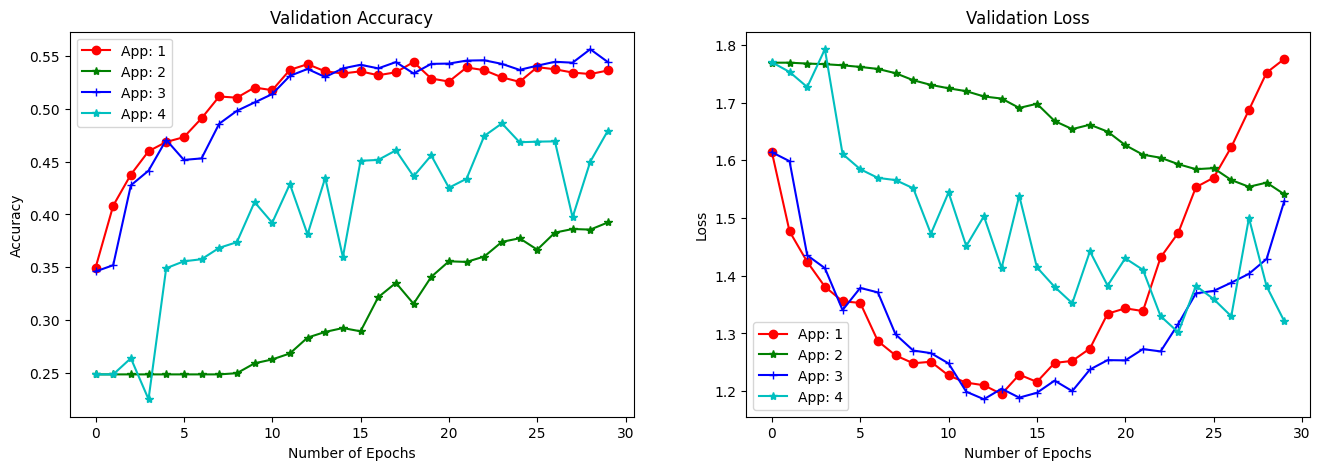

In [8]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(range(approaches[0]['Epoch']), ALL_HIST[0]['val_acc'], '-o', color='r', label='App: 1')
plt.plot(range(approaches[1]['Epoch']), ALL_HIST[1]['val_acc'], '-*', color='g', label='App: 2')
plt.plot(range(approaches[2]['Epoch']), ALL_HIST[2]['val_acc'], '-+', color='b', label='App: 3')
plt.plot(range(approaches[3]['Epoch']), ALL_HIST[3]['val_acc'], '-*', color='c', label='App: 4')

plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")

plt.legend()


plt.subplot(1,2,2)
plt.plot(range(approaches[0]['Epoch']), ALL_HIST[0]['val_loss'], '-o', color='r', label='App: 1')
plt.plot(range(approaches[1]['Epoch']), ALL_HIST[1]['val_loss'], '-*', color='g', label='App: 2')
plt.plot(range(approaches[2]['Epoch']), ALL_HIST[2]['val_loss'], '-+', color='b', label='App: 3')
plt.plot(range(approaches[3]['Epoch']), ALL_HIST[3]['val_loss'], '-*', color='c', label='App: 4')

plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")

plt.legend()



plt.show()


واضح است که رویکرد اول هم با معیار دقت هم با معیار لاس بهترین عملکرد را دارد. بنابراین مدل خود را به این صورت انتخاب کرده و آن را مجدد آموزش میدهیم و بعد برروی داده های تست بررسی میکنیم

Test set accuracy = 53.69374469289556 %


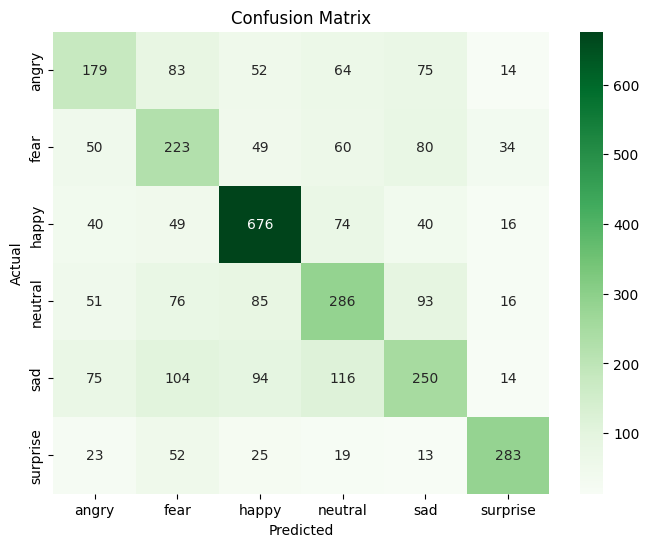

In [9]:
test_acc=0
model = ALL_MODELS[0]
model.eval()

y_predc = []

with torch.no_grad():
	for i, (images, labels) in enumerate(test_loader):

		images = images.to(device)
		y_true = labels.to(device)

		outputs = model(images.float())

		_, y_pred = torch.max(outputs.data, 1)

		y_pred2 = y_pred.cpu().numpy().tolist()
		y_predc = y_predc + y_pred2

		test_acc += (y_pred == y_true).sum().item()

	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

conf_mat = confusion_matrix(y_test.to('cpu'), y_predc)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

واضح است با استفاده از مدل «سی ان ان» به دقت خیلی بالاتری نسبت به مدل های مبتنی بر «پرسپترون» برسیم. دقت ما در پرسپترون چند لایه حدود 44 درصد بود

### امتیازی
## تعداد پارامتر های هر مدل

MLP: $\Sigma_{i=1}^{N_{Layer}}N_x\times N_p = (48×48×256) + (256×512) + (512×64)+(64×6) = 754,048 $

CNN: $\Sigma ConvLayers + \Sigma FCLayers = \Sigma((h_f\times w_f\times N_{PrevFilt})+1)\times N_{CurrFilt} +   \Sigma_{i=1}^{N_{Layer}}N_x\times N_p = ((3\times 3\times1)+1)\times 16 +  ((3\times 3\times 16)+1)\times 32 + ((3\times 3\times 32)+1)\times 32 +  (32\times 6\times 6\times 512)+(512 \times 6) = 606,944$

واضح است مدل «سی ان ان» در عین حال که دقت بسیار بیشتری داشته است پارامتر های یادگیری کمتری هم نسبت به مدل «ام ال پی» دارد

### DropOut افزودن لایه

در مورد بهترین مدل قسمت قبل دیدیم که واضحا اورفیت شده است. چرا که دقت مدل بر روی داده های ترین به حدود 90 درصد رسید ولی دقت برای داده های ولیدیشن برروی حدود 54 درصد پس از مدتی ثابت ماند و دقت مدل برای داده های تست هم همین عدد 54 بود. بنابراین لایه های دراپ اوت اضافه میکنیم

In [22]:
class MyCnnDropout(nn.Module):
    def __init__(self):
        super(MyCnnDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout1 = torch.nn.Dropout2d(0.2)

        self.conv2 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout2 = torch.nn.Dropout2d(0.3)

        self.conv3 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.dropout3 = torch.nn.Dropout2d(0.3)


        self.fc1 = torch.nn.Linear(32*6*6, 512)
        self.dropout_fc = torch.nn.Dropout2d(0.2)
        self.fc2 = torch.nn.Linear(512, 6)

    def forward(self, x):
        x = self.dropout1(self.pool1(torch.relu(self.conv1(x))))
        x = self.dropout2(self.pool2(torch.relu(self.conv2(x))))
        x = self.dropout3(self.pool3(torch.relu(self.conv3(x))))

        x = x.view(-1, 32*6*6)

        x = self.dropout_fc(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [23]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=aprch['Batch'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=aprch['Batch'], shuffle=False)

model = MyCnnDropout().to(device)
learning_rate = 0.0001
weight_decay = 0.001
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

history = {
  'loss': [],
  'val_loss': [],
  'acc': [],
  'val_acc': []
}
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        # print(labels.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()



    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Accuracy: {train_correct / train_total:.4f} - "
          f"Train Loss: {train_loss / len(train_loader):.4f} - "
          f"Validation Accuracy: {val_correct / val_total:.4f} - "
          f"Validation Loss: {val_loss / len(val_loader):.4f}")

    history['acc'].append(train_correct / train_total)
    history['loss'].append(train_loss / len(train_loader))
    history['val_acc'].append(val_correct / val_total)
    history['val_loss'].append(val_loss / len(val_loader))

Epoch 1/100 - Train Accuracy: 0.2537 - Train Loss: 1.7580 - Validation Accuracy: 0.2541 - Validation Loss: 1.7373
Epoch 2/100 - Train Accuracy: 0.2739 - Train Loss: 1.7178 - Validation Accuracy: 0.3045 - Validation Loss: 1.6812
Epoch 3/100 - Train Accuracy: 0.3154 - Train Loss: 1.6684 - Validation Accuracy: 0.3574 - Validation Loss: 1.6238
Epoch 4/100 - Train Accuracy: 0.3490 - Train Loss: 1.6178 - Validation Accuracy: 0.3843 - Validation Loss: 1.5735
Epoch 5/100 - Train Accuracy: 0.3719 - Train Loss: 1.5826 - Validation Accuracy: 0.4015 - Validation Loss: 1.5422
Epoch 6/100 - Train Accuracy: 0.3841 - Train Loss: 1.5646 - Validation Accuracy: 0.4089 - Validation Loss: 1.5263
Epoch 7/100 - Train Accuracy: 0.3899 - Train Loss: 1.5454 - Validation Accuracy: 0.4140 - Validation Loss: 1.5152
Epoch 8/100 - Train Accuracy: 0.3986 - Train Loss: 1.5329 - Validation Accuracy: 0.4072 - Validation Loss: 1.4945
Epoch 9/100 - Train Accuracy: 0.4046 - Train Loss: 1.5194 - Validation Accuracy: 0.4199 

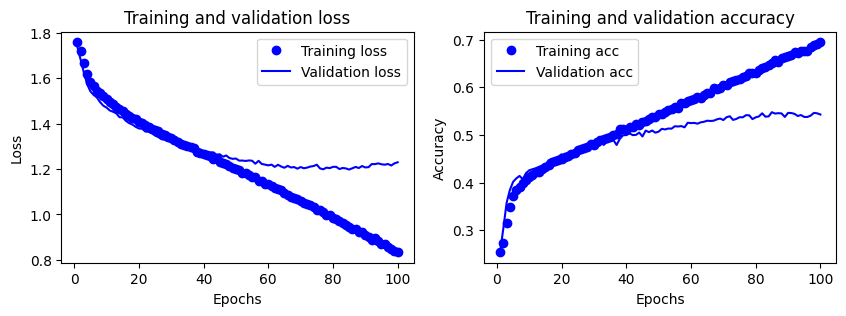

Test set accuracy = 55.561845457118594 %


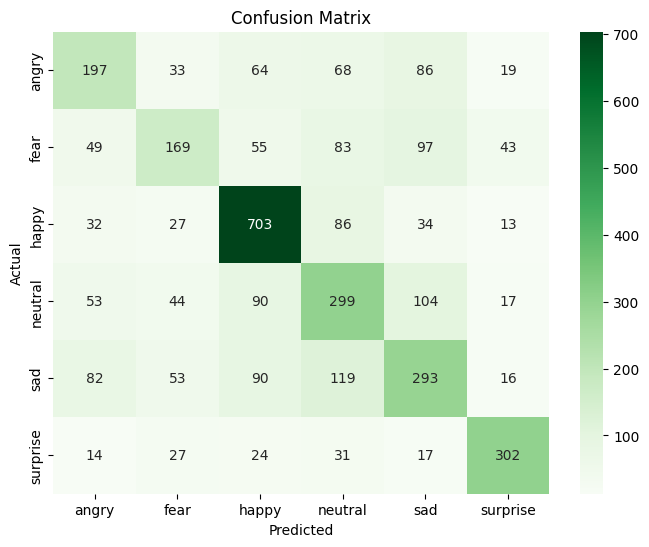

In [24]:
visualize_loss_and_acc(history)



test_acc=0
model.eval()

y_predc = []

with torch.no_grad():
	for i, (images, labels) in enumerate(test_loader):

		images = images.to(device)
		y_true = labels.to(device)

		outputs = model(images.float())

		_, y_pred = torch.max(outputs.data, 1)

		y_pred2 = y_pred.cpu().numpy().tolist()
		y_predc = y_predc + y_pred2

		test_acc += (y_pred == y_true).sum().item()

	print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

conf_mat = confusion_matrix(y_test.to('cpu'), y_predc)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

میبینیم که اضافه کردن لایه های «دراپ اوت» در دقت نهایی تاثیر گذار بوده اما تاثیر بسیار زیادی نداشته است

## امتیازی: سایر روش های رگولاریزیشن

1) Early Stopping
بجای آنکه روش آموزش خود را اجبار کنیم که حتما تعداد خاصی از ایپاک ها را طی کند، زمانی که میبینیم دقت مدل بر روی داده های ولیدیشن تقریبا ثابت شده است آن را متوقف کنیم تا از اورفیتینگ جلوگیری کنیم

2) L1,L2 Regularization
در روش اول مقدار عددی وزن ها را به لاس محاسبه شده اضافه میکنیم تا برخی ضرایب صفر شوند. این برای حالتی که میدانیم برخی ویژگی های ورودی مفید نیستند عملکرد مناسبی خواهد داشت

در مورد بعدی نیز مجذور وزن ها را به لاس اضافه میکند تا از زیادی بزرگ شدن وزن ها جلوگیری کند



منبع: https://medium.com/@sruthy.sn91/regularization-techniques-preventing-overfitting-in-deep-learning-2cddb7822217